In [4]:
import os
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# === CONFIG: edit these for your setup ===
# MODEL_PATH = "runs/detect/nail-detector/weights/best.pt"  # path to your trained model

MODEL_PATH = "yolov8n.pt" 
# IMAGE_PATH = "data/test/finger_01.jpg"                    # path to a test image

IMAGE_PATH = "Fingernails/test/10125_jpg.rf.874dada59c3a6f742a5ce34591f204d2.jpg"

OUT_DIR = "outputs"                                       # where to save results
CONF_THRES = 0.25                                         # detection confidence threshold

os.makedirs(OUT_DIR, exist_ok=True)

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="MbzUz7D6WpOwnPEmWmck")
project = rf.workspace("fingernail-ztwys").project("fingernails-xb812")
version = project.version(11)
dataset = version.download("yolov8")
                

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/54.8 MB ? eta -:--:--Downloading opencv_python_headless-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl (54.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 33.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 33.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/892.3 kB ? eta -:--:--Downloading pi_heif-1.1.1-cp313-cp313-macosx_11_0_arm64.whl (892 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.3/892.3 kB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.3/892.3 kB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/2.8 MB ? eta -:--:--Downloading pillow_avif_plugin-1.5.2-cp313-cp313-macosx_11_0_arm64.whl (2.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [roboflow]4/5 [robof


Extracting Dataset Version Zip to Fingernails-11 in yolov8:: 100%|██████████| 2412/2412 [00:00<00:00, 6872.34it/s]
Extracting Dataset Version Zip to Fingernails-11 in yolov8:: 100%|██████████| 2412/2412 [00:00<00:00, 6872.34it/s]


# YOLOv8 Training on Roboflow Dataset

This section trains a YOLOv8 model on the downloaded Roboflow dataset.
Steps:
1. Confirm dataset download and locate `data.yaml`.
2. Initialize (or choose) a YOLOv8 model size (`n`, `s`, `m`, `l`, `x`).
3. Run `model.train()` with desired hyperparameters (epochs, imgsz, batch, patience).
4. Inspect results in `runs/detect/nail-detector/` (weights, metrics, confusion matrix).
5. Run inference on a sample image and optionally export.

Adjust epochs and model size upward for better accuracy once the pipeline works.

In [2]:
# Locate Roboflow dataset folder and data.yaml
import os

# Roboflow download returns an object with a .location attribute (root folder)
dataset_dir = dataset.location  # e.g., 'Fingernails-11' or similar
print("Dataset directory:", dataset_dir)

# data.yaml describes train/val/test splits and class names
data_yaml = os.path.join(dataset_dir, "data.yaml")
print("data.yaml path:", data_yaml)

# Quick peek at first lines (optional)
with open(data_yaml, "r") as f:
    for i, line in enumerate(f):
        if i >= 25:  # limit output
            break
        print(line.rstrip())

Dataset directory: /Users/lindbergsimpson/Documents/CMU Heinz AIM/Intro to AI/NailDiseaseClassification/Fingernails-11
data.yaml path: /Users/lindbergsimpson/Documents/CMU Heinz AIM/Intro to AI/NailDiseaseClassification/Fingernails-11/data.yaml
names:
- Fingernail
nc: 1
roboflow:
  license: CC BY 4.0
  project: fingernails-xb812
  url: https://universe.roboflow.com/fingernail-ztwys/fingernails-xb812/dataset/11
  version: 11
  workspace: fingernail-ztwys
test: ../test/images
train: ../train/images
val: ../valid/images


In [ ]:
!pip install ultralytics opencv-python

In [5]:
# Train YOLOv8 model
from ultralytics import YOLO

# Choose model size (yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt)
# Start with a small model for a faster sanity check, scale up later.
train_model = YOLO("yolov8n.pt")

train_results = train_model.train(
    data=data_yaml,      # path to data.yaml
    epochs=20,           # increase for better performance (e.g., 100-300)
    imgsz=512,           # can try 512 or 768 depending on GPU memory
    batch=16,            # adjust to fit GPU RAM (auto if None)
    device="mps",
    patience=10,         # early stopping patience
    pretrained=True,     # use pretrained weights
    project="runs",      # root results directory
    name="nail-detector",# subdirectory for this experiment
    optimizer="AdamW",     # try 'AdamW' for potentially faster convergence
    lr0=0.005,            # initial learning rate
    close_mosaic=0       # keep mosaic augmentation (set >0 to disable near end)
)

print("Training complete. Best weights at: runs/detect/nail-detector/weights/best.pt")

Ultralytics 8.3.231 🚀 Python-3.13.5 torch-2.9.1 MPS (Apple M3 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/Users/lindbergsimpson/Documents/CMU Heinz AIM/Intro to AI/NailDiseaseClassification/Fingernails-11/data.yaml, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=nail-detector2, nbs=64, nms=False, opset=None, optimize=False, optimizer=A

In [18]:
%matplotlib inline
from IPython import get_ipython
get_ipython().run_line_magic("config", "InlineBackend.figure_formats = ['retina']")

Loaded trained model.

image 1/1 /Users/lindbergsimpson/Documents/CMU Heinz AIM/Intro to AI/NailDiseaseClassification/nail disease.png: 352x512 3 Fingernails, 29.9ms
Speed: 1.1ms preprocess, 29.9ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 512)
image 1/1 /Users/lindbergsimpson/Documents/CMU Heinz AIM/Intro to AI/NailDiseaseClassification/nail disease.png: 352x512 3 Fingernails, 29.9ms
Speed: 1.1ms preprocess, 29.9ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 512)


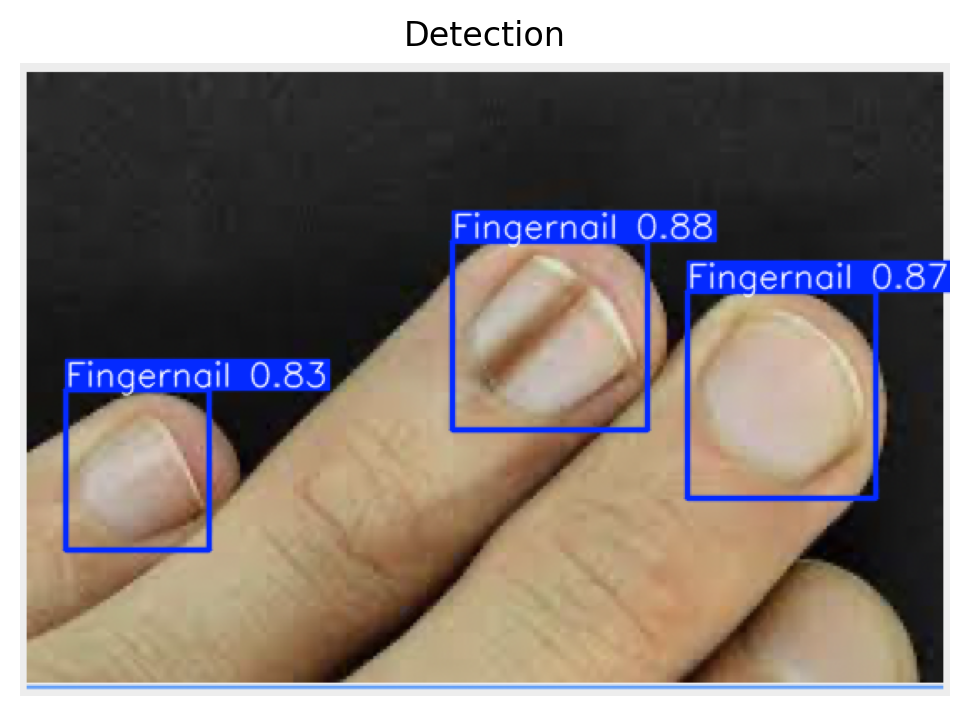

In [23]:
# Inference with best trained weights
from ultralytics import YOLO

best_weights = "runs/nail-detector2/weights/best.pt"
assert os.path.exists(best_weights), f"Best weights not found: {best_weights}"

trained_model = YOLO(best_weights)
print("Loaded trained model.")

# Use the same IMAGE_PATH defined earlier or set a new test image
# IMAGE_PATH = "Fingernails-11/test/images/10831_jpg.rf.012f77bd3fa1935099f1c743bada0e7c.jpg"
IMAGE_PATH = "nail disease.png"
test_image = IMAGE_PATH

infer_results = trained_model(test_image)
# Display results inline (Ultralytics auto-handles plotting if in notebook)
for r in infer_results:
    annotated = r.plot()  # BGR
    annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(annotated_rgb)
    ax.axis("off")
    ax.set_title("Detection")
    display(fig)   # ensures inline rendering
    plt.close(fig) # prevents duplicate textual representation

# Access detections programmatically
# boxes = infer_results[0].boxes
# print(f"Detections: {len(boxes)}")
# if len(boxes):
#     print("First box confidence:", float(boxes.conf[0]))